In [18]:
import numpy as np 
import pandas as pd
from collections import Counter
df = pd.read_csv('dataset-63314.csv')
df['default'] = df['default'].apply(lambda x: 1 if x == 'Yes' else 0)
df['student'] = df['student'].apply(lambda x: 1 if x == 'Yes' else 0)
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


# Ex 1

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
train_x = train[['student', 'balance', 'income']].values
test_x = test[['student', 'balance', 'income']].values
train_y = train['default'].values
test_y = test['default'].values
train.head()

,default,student,balance,income
8487,0,0,680.706469,42316.403112
7697,0,0,917.856227,49353.950634
9122,0,1,1017.360966,21702.183103
4501,0,1,1310.793503,16742.952524
8315,0,1,1343.777124,28198.005353


In [20]:
def learn_LDA(train_x, train_y):
    # A function that takes as an input a matrix of coefficients and a vector of classes
    # and it trains the model (for the training data).
    covariance = np.cov(train_x.T)
    means = [train_x[train_y == 0].mean(axis=0), 
             train_x[train_y == 1].mean(axis=0)]
    priors = Counter(train_y.flatten())
    priors = [priors[class_]/len(train_y) for class_ in [0, 1]]
    model = {'covariance': covariance,
        'means': means,
        'priors': priors}
    return model
model = learn_LDA(train_x, train_y)
model

{'covariance': array([[ 2.07383673e-01,  4.54951563e+01, -4.56835356e+03],
        [ 4.54951563e+01,  2.34268863e+05, -1.02062504e+06],
        [-4.56835356e+03, -1.02062504e+06,  1.76292719e+08]]),
 'means': [array([2.90109890e-01, 8.03071198e+02, 3.36007524e+04]),
  array([3.92452830e-01, 1.76669697e+03, 3.15657233e+04])],
 'priors': [0.966875, 0.033125]}

In [21]:
def return_gausian_prob(x, means, covariance):
    result = (x-means)
    conv_inv = np.linalg.inv(covariance)
    result = np.apply_along_axis(lambda x: x @ conv_inv, 1, result)
    
    result = -0.5*np.apply_along_axis(lambda x: x @ (x-means), 1, result)

    
    result = np.exp(result)
    
    
    result = result*((2*np.pi)**x.shape[1]*np.linalg.det(covariance))**-0.5
    
    return result

In [22]:
def inference_LDA(x, model):
    # A  function that takes as an input a matrix of coefficients and it returns posterior
    # distributions (for the test data)
    class_1_gausian_prob = return_gausian_prob(x, model['means'][1], model['covariance'])
    class_0_gausian_prob = return_gausian_prob(x, model['means'][0], model['covariance'])
    numerator = class_1_gausian_prob*model['priors'][1]
    denominator = numerator + class_0_gausian_prob*model['priors'][0]
    return numerator/denominator
y_pred = inference_LDA(test_x, model)
y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred])
sum(y_pred == test_y)/len(test_y)

0.966

In [23]:
def learn_QDA(train_x, train_y):
    # A function that takes as an input a matrix of coefficients and a vector of classes
    # and it trains the model (for the training data).
    covariances = [np.cov(train_x[train_y == 0].T), np.cov(train_x[train_y == 1].T)]
    means = [train_x[train_y == 0].mean(axis=0), 
             train_x[train_y == 1].mean(axis=0)]
    priors = Counter(train_y.flatten())
    priors = [priors[class_]/len(train_y) for class_ in [0, 1]]
    model = {'covariances': covariances,
        'means': means,
        'priors': priors}
    return model
model = learn_QDA(train_x, train_y)
model

{'covariances': [array([[ 2.05972770e-01,  4.25621534e+01, -4.53611074e+03],
         [ 4.25621534e+01,  2.07767127e+05, -9.74452254e+05],
         [-4.53611074e+03, -9.74452254e+05,  1.75767130e+08]]),
  array([[ 2.39336764e-01,  3.58764547e+01, -5.32809153e+03],
         [ 3.58764547e+01,  1.10320234e+05, -4.73913476e+05],
         [-5.32809153e+03, -4.73913476e+05,  1.88338526e+08]])],
 'means': [array([2.90109890e-01, 8.03071198e+02, 3.36007524e+04]),
  array([3.92452830e-01, 1.76669697e+03, 3.15657233e+04])],
 'priors': [0.966875, 0.033125]}

In [24]:
def inference_QDA(x, model):
    # A  function that takes as an input a matrix of coefficients and it returns posterior
    # distributions (for the test data)
    class_1_gausian_prob = return_gausian_prob(x, model['means'][1], model['covariances'][1])
    class_0_gausian_prob = return_gausian_prob(x, model['means'][0], model['covariances'][0])
    numerator = class_1_gausian_prob*model['priors'][1]
    denominator = numerator + class_0_gausian_prob*model['priors'][0]
    return numerator/denominator
y_pred = inference_QDA(test_x, model)
y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred])
sum(y_pred == test_y)/len(test_y)

0.9655

### Comparison with sklearn

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis().fit(train_x, train_y)
clf.score(test_x, test_y)

0.9685

In [26]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis().fit(train_x, train_y)
clf.score(test_x, test_y)

0.9715

# Ex 2

### a

In [27]:
Y = np.random.choice([0, 1], size=n)

In [28]:
from scipy import stats
distr_0 = stats.multivariate_normal([0, 0], [[1,0], [0,1]])
distr_1 = stats.multivariate_normal([1, 1], [[1,0], [0,1]])

In [29]:
X = np.array([distr_0.rvs() if y==0 else distr_1.rvs() for y in Y])

In [30]:
clf = LinearDiscriminantAnalysis().fit(X, Y)
clf.score(X, Y)

0.772

In [31]:
clf = QuadraticDiscriminantAnalysis().fit(X, Y)
clf.score(X, Y)

0.772

### b

In [32]:
Y = np.random.choice([0, 1], size=n)

from scipy import stats
distr_0 = stats.multivariate_normal([0, 0], [[1,0.8], [0.8,1]])
distr_1 = stats.multivariate_normal([1, 1], [[1,-0.8], [-0.8,1]])
X = np.array([distr_0.rvs() if y==0 else distr_1.rvs() for y in Y])

In [33]:
LinearDiscriminantAnalysis().fit(X, Y).score(X, Y)

0.816

In [34]:
QuadraticDiscriminantAnalysis().fit(X, Y).score(X, Y)


0.857

## Ex 3

In [35]:
Y = np.random.choice([0, 1], size=n)
Counter(Y)

Counter({1: 519, 0: 481})

In [36]:
means = [0.25, 0.5, 0.75, 1]
corrs = np.linspace(0, 0.99, 25)
def return_LDA_QDA_acc(mean, corr, k=100):
    Y = np.random.choice([0, 1], size=n)
    data = []
    for i in range(k):
        distr_0 = stats.multivariate_normal([0, 0], [[1,corr], [corr,1]])
        distr_1 = stats.multivariate_normal([mean, mean], [[1,-corr], [-corr,1]])
        X = np.array([distr_0.rvs() if y==0 else distr_1.rvs() for y in Y])
        data.append((LinearDiscriminantAnalysis().fit(X, Y).score(X, Y), QuadraticDiscriminantAnalysis().fit(X, Y).score(X, Y)))
    return np.array(data).mean(axis=0)

In [37]:
data = [np.zeros(shape=(len(means), len(corrs))), np.zeros(shape=(len(means), len(corrs)))]
for i, mean in enumerate(means): 
    for j, corr in enumerate(corrs): 
        LDA_acc, QDA_acc = return_LDA_QDA_acc(mean, corr)
        data[0][i,j] = LDA_acc
        data[1][i,j] = QDA_acc
        
LDA = pd.DataFrame(data[0], columns=corrs, index=means)
QDA = pd.DataFrame(data[1], columns=corrs, index=means)


In [38]:
LDA

,0.00000,0.04125,0.08250,0.12375,0.16500,0.20625,0.24750,0.28875,0.33000,0.37125,...,0.61875,0.66000,0.70125,0.74250,0.78375,0.82500,0.86625,0.90750,0.94875,0.99000
0.25,0.57392,0.57867,0.57192,0.56846,0.56883,0.57195,0.56985,0.57100,0.56256,0.60212,...,0.59338,0.55389,0.51864,0.60587,0.64823,0.58968,0.62499,0.55247,0.48174,0.67967
0.50,0.63589,0.64331,0.63715,0.63782,0.63908,0.64136,0.63798,0.63773,0.64971,0.64294,...,0.64381,0.66993,0.63725,0.67077,0.69693,0.72208,0.73118,0.73284,0.76899,0.79161
0.75,0.70297,0.70618,0.70384,0.70106,0.70329,0.70396,0.70930,0.70607,0.70835,0.71284,...,0.74530,0.73783,0.74979,0.75315,0.75697,0.77173,0.77696,0.79350,0.81117,0.82376
1.00,0.75933,0.76180,0.76140,0.76124,0.76483,0.76162,0.76342,0.76529,0.77125,0.76317,...,0.79320,0.79875,0.80179,0.80284,0.82989,0.82640,0.82964,0.83962,0.84777,0.84689


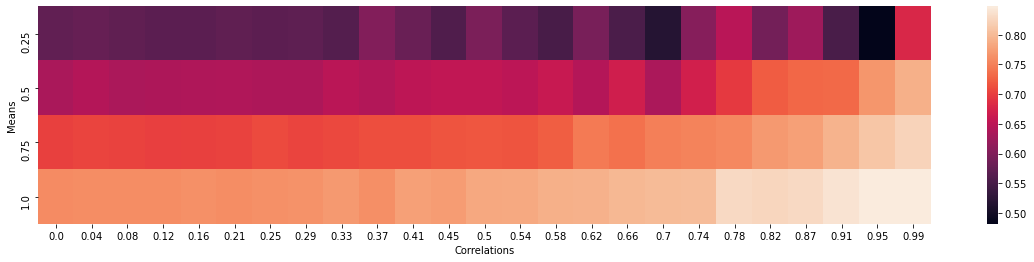

In [43]:
import seaborn as sn
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 4))

sn.heatmap(LDA, ax=ax)
ax.set_xticklabels([round(cor, 2) for cor in corrs])
plt.xticks(rotation=0)
ax.set_xlabel('Correlations')
_ = ax.set_ylabel('Means')

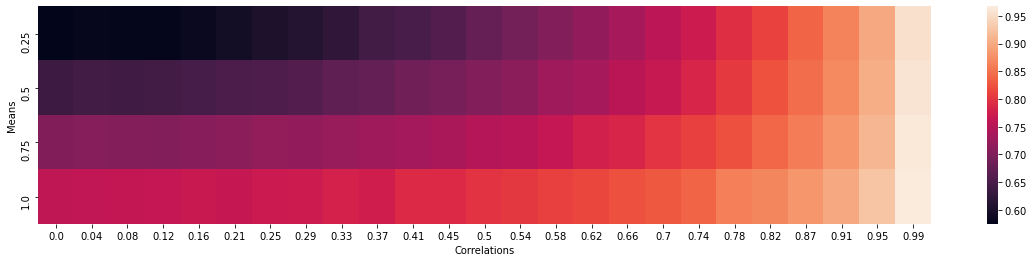

In [44]:
import seaborn as sn
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 4))
sn.heatmap(QDA, ax=ax)
ax.set_xticklabels([round(cor, 2) for cor in corrs])

plt.xticks(rotation=0)
ax.set_xlabel('Correlations')
_ = ax.set_ylabel('Means')